<a href="https://colab.research.google.com/github/WittmannF/machine-learning-web-app/blob/master/2-preprocessamento/2_b_DA_e_Preprocessamento_Producao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [0]:
# Parametros
URL_DADOS = 'https://raw.githubusercontent.com/WittmannF/machine-learning-web-app/master/dados_calculadora_imoveis.csv'

LIMITE_PRECO = 100000 # Valor maximo de aluguel
LIMITE_AREA = 2500

In [0]:
# Funcoes
def ler_dividir_dados():
    df = pd.read_csv(URL_DADOS); df

    X_train, X_test, y_train, y_test = train_test_split(df[['zona','quartos','area']], 
                                                        df['preco'], 
                                                        stratify=df['zona'], 
                                                        test_size=0.25,
                                                        random_state=0
                                                        )
    treino = pd.concat([X_train, y_train], axis=1)
    teste = pd.concat([X_test, y_test], axis=1)

    treino.to_csv('treino.csv', index=False)
    teste.to_csv('teste.csv', index=False)

    return treino, teste

def filtrar_dados(df, limite_preco, limite_area):
    df_limpo = df[(df['preco']<=limite_preco)&(df['area']<=limite_area)]
    return df_limpo

def preencher_nan_quarto(df, teste):
    df_limpo = df.copy()
    teste_limpo = teste.copy()

    reg = RandomForestRegressor()
    X_fillna = df_limpo.loc[~df_limpo['quartos'].isna(),'area']
    y_fillna = df_limpo.loc[~df_limpo['quartos'].isna(),'quartos']
    reg.fit(X_fillna.values.reshape(-1, 1), y_fillna.values)

    # Preencher NaNs para conjunto de treino
    X_fillna_pred = df_limpo.loc[df_limpo['quartos'].isna(),'area'].values.reshape(-1, 1)
    y_fillna_pred = reg.predict(X_fillna_pred).astype(int)
    df_limpo.loc[df_limpo['quartos'].isna(),'quartos'] = y_fillna_pred
    
    # Preencher NaNs para o conjunto de teste
    X_test_pred = teste_limpo.loc[teste_limpo['quartos'].isna(),'area'].values.reshape(-1, 1)
    y_test_pred = reg.predict(X_test_pred).astype(int)
    teste_limpo.loc[teste_limpo['quartos'].isna(),'quartos'] = y_test_pred

    return df_limpo, teste_limpo

def log_transform(df_limpo, teste):
    df_limpo['preco'] = df_limpo['preco'].apply(np.log1p)
    df_limpo['quartos'] = df_limpo['quartos'].apply(np.log1p)
    df_limpo['area'] = df_limpo['area'].apply(np.log1p)

    # Tratar conjunto de testes
    teste['quartos'] = teste['quartos'].apply(np.log1p)
    teste['area'] = teste['area'].apply(np.log1p)
    return df_limpo, teste

def aplicar_one_hot_zona(df_limpo):
    zona_one_hot = pd.get_dummies(df_limpo['zona'], drop_first=True)
    return pd.concat([zona_one_hot, df_limpo[['quartos','area','preco']]], axis=1)

In [0]:
# 1. Leitura e divisao dos dados
treino, teste = ler_dividir_dados()

In [5]:
# 2. Análise Exploratoria Antes
treino.head()

,zona,quartos,area,preco
18,norte,3.0,300.0,1600.0
461,sul,3.0,150.0,4000.0
249,norte,4.0,400.0,6000.0
632,leste,2.0,55.0,950.0
458,sul,4.0,495.0,5000.0


In [6]:
treino.describe()

,quartos,area,preco
count,804.000000,864.000000,8.640000e+02
mean,2.598259,176.914352,8.524549e+03
std,1.562017,160.104802,6.585445e+04
min,1.000000,1.000000,3.000000e+02
25%,2.000000,60.000000,1.200000e+03
50%,2.000000,125.000000,2.500000e+03
75%,3.000000,234.000000,5.500000e+03
max,17.000000,1000.000000,1.800000e+06


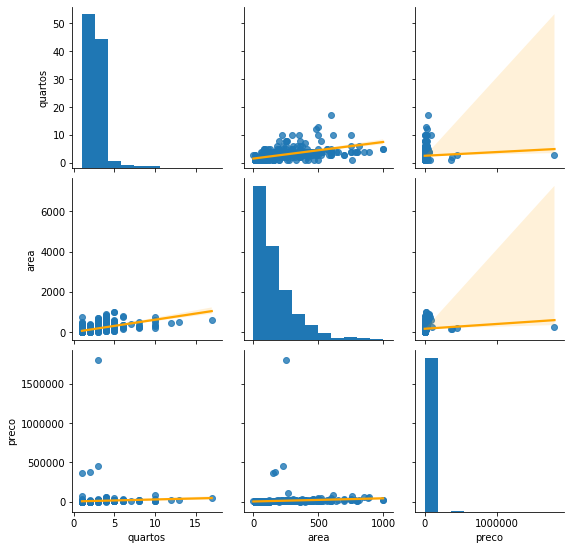

In [7]:
sns.pairplot(treino, kind='reg', plot_kws={'line_kws':{'color':'orange'}})

In [0]:
# 3. Limpeza dos dados e remocao dos outliers
treino_prep = filtrar_dados(treino, LIMITE_PRECO, LIMITE_AREA)

In [0]:
# 4. Preencher NaNs do Quarto
treino_prep, teste_prep = preencher_nan_quarto(treino_prep, teste)

In [0]:
# 5. Aplicar transformacao logaritmica 
treino_prep, teste_prep = log_transform(treino_prep, teste_prep)

In [0]:
# 6. Tratamento da coluna categorica 'zona'
treino_prep = aplicar_one_hot_zona(treino_prep)
teste_prep = aplicar_one_hot_zona(teste_prep)

In [0]:
# 7. Exportar base para CSV
treino_prep.to_csv('treino_preprocessado.csv', index=False)
teste_prep.to_csv('teste_preprocessado.csv', index=False)

In [13]:
# 8. Analise Exploratória Pós Preprocessamento
treino_prep.head()

,norte,oeste,sul,quartos,area,preco
18,1,0,0,1.386294,5.707110,7.378384
461,0,0,1,1.386294,5.017280,8.294300
249,1,0,0,1.609438,5.993961,8.699681
632,0,0,0,1.098612,4.025352,6.857514
458,0,0,1,1.609438,6.206576,8.517393


In [14]:
treino_prep.describe()

,norte,oeste,sul,quartos,area,preco
count,859.000000,859.000000,859.000000,859.000000,859.000000,859.000000
mean,0.251455,0.250291,0.247963,1.213062,4.807831,7.902039
std,0.434102,0.433433,0.432082,0.365350,0.901770,1.031470
min,0.000000,0.000000,0.000000,0.693147,0.693147,5.707110
25%,0.000000,0.000000,0.000000,1.098612,4.110874,7.090910
50%,0.000000,0.000000,0.000000,1.098612,4.795791,7.783641
75%,1.000000,0.500000,0.000000,1.386294,5.446728,8.612685
max,1.000000,1.000000,1.000000,2.890372,6.908755,11.407576


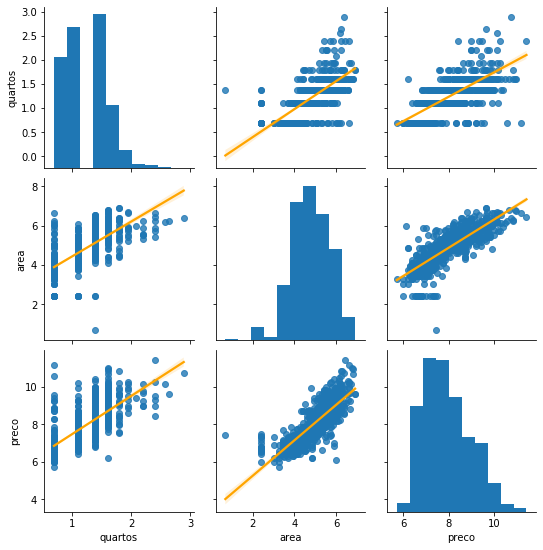

In [15]:
cols = ['quartos','area','preco']
sns.pairplot(treino_prep[cols], kind='reg', plot_kws={'line_kws':{'color':'orange'}})